In [1]:
import os
os.chdir('../../src')
# print(os.getcwd())

import datetime
import torch
import torch.nn as nn

from transformer.models import Transformer
from neural_process.models import LNP
from data import GPCurvesReader
from utils import plot_model_comparisons

In [2]:
tf_model = Transformer(x_dim=1, y_dim=1)
tf_model.load_state_dict(torch.load('../models/1d_toy_regression/Transformer.pt', weights_only=True))
tf_model.eval()

np_model = LNP(x_dim=1, y_dim=1)
np_model.load_state_dict(torch.load('../models/1d_toy_regression/LNP.pt', weights_only=True))
np_model.eval()

LNP(
  (decoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=129, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=2, bias=True)
  )
  (encoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=128, bias=True)
  )
  (latent_encoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=256, bias=True)
  )
  (reshape_r_z): Linear

In [5]:
MAX_CONTEXT_POINTS = 10

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


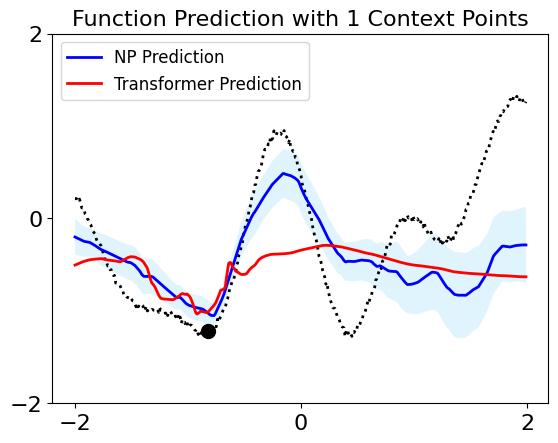

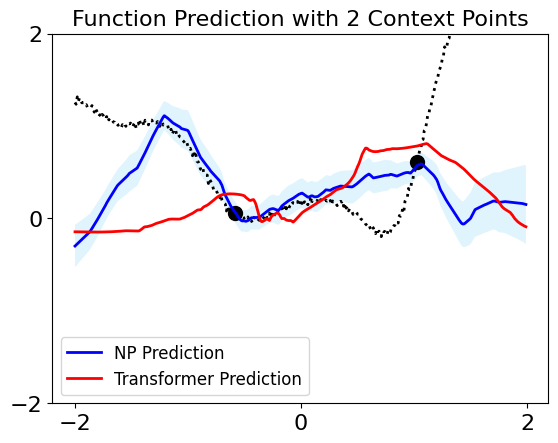

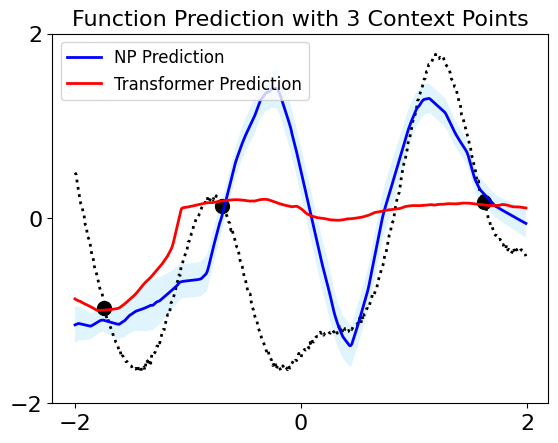

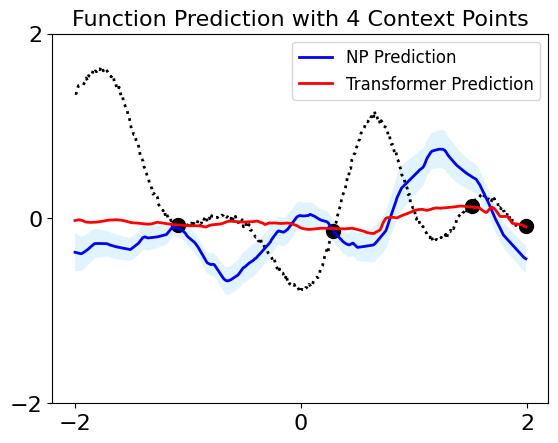

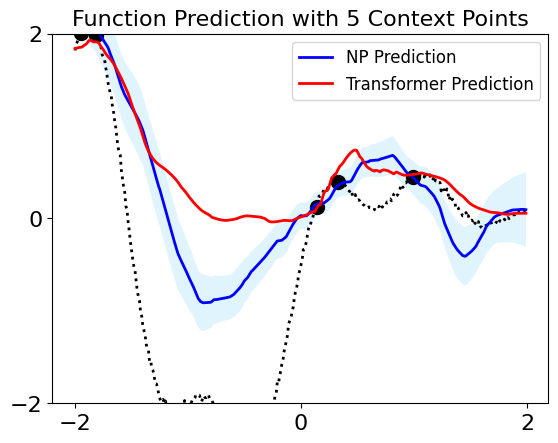

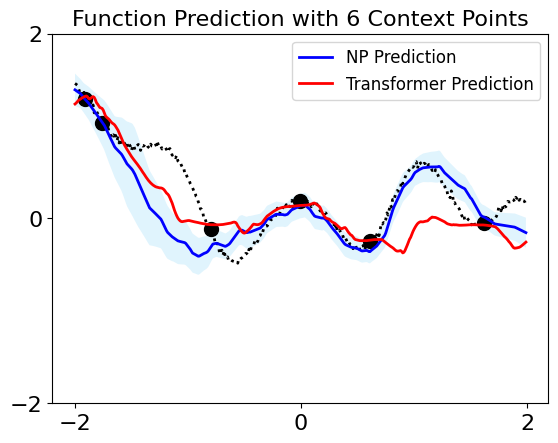

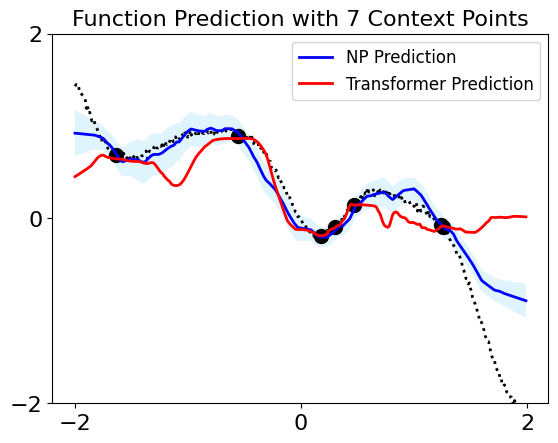

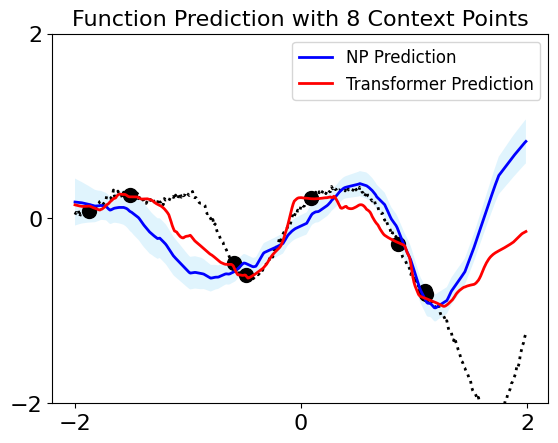

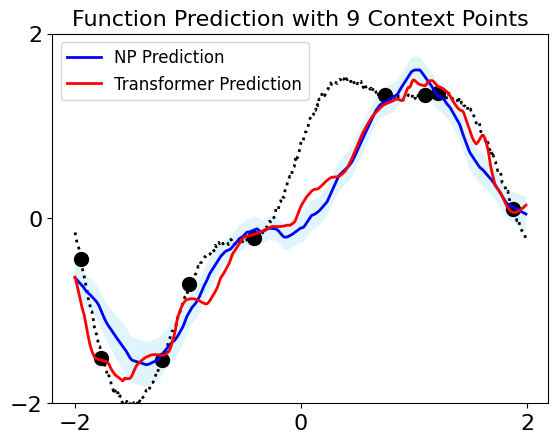

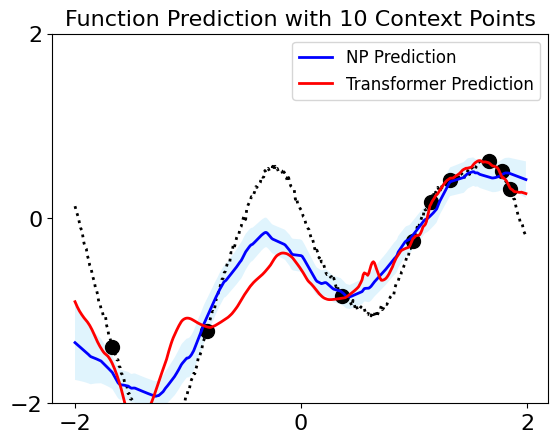

In [7]:
np_model.to(device)
tf_model.to(device)

with torch.no_grad():

    for num_context in range(1, MAX_CONTEXT_POINTS + 1):

        data_test = dataset_test.generate_curves(num_context=num_context)
        context_x, context_y, target_x, target_y, _, _ = data_test
        context_x = context_x.to(device)
        context_y = context_y.to(device)
        target_x = target_x.to(device)
        target_y = target_y.to(device)

        # Neural Process
        np_pred_y, _, _, _ = np_model(context_x, context_y, target_x)
        np_pred_y_mean = np_pred_y.mean.mean(0)
        np_pred_y_std = np_pred_y.stddev.mean(0)

        # Transformer
        tf_preds = []
        for i in range(target_x.size(1)):
            x_t = target_x[:, i:i+1, :]
            pred = tf_model(context_x, context_y, x_t)
            tf_preds.append(pred)
        tf_pred_y = torch.cat(tf_preds, dim=1)

        # Plot Functions
        plot_model_comparisons(
            target_x.detach().cpu().numpy(),
            target_y.detach().cpu().numpy(),
            context_x.detach().cpu().numpy(),
            context_y.detach().cpu().numpy(),
            np_pred_y_mean.detach().cpu().numpy(),
            np_pred_y_std.detach().cpu().numpy(),
            tf_pred_y.detach().cpu().numpy(),
            num_context,
            save_fig=f"../images/1d_toy_regression/np_vs_tf_{num_context}_context.png",
        )

#### The performance of the Transformer model deteriorates when num_context increases >10


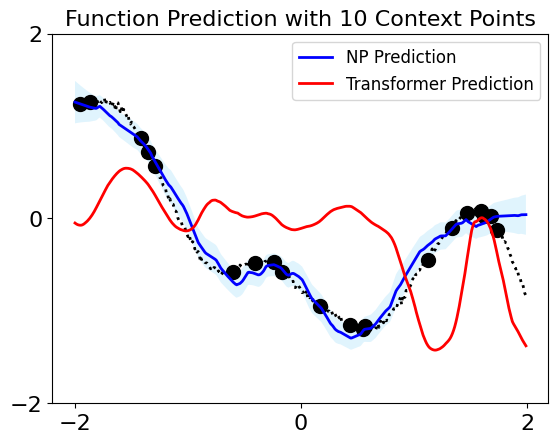

In [8]:
with torch.no_grad():

    data_test = dataset_test.generate_curves(num_context=20)
    context_x, context_y, target_x, target_y, _, _ = data_test
    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)

    # Neural Process
    np_pred_y, _, _, _ = np_model(context_x, context_y, target_x)
    np_pred_y_mean = np_pred_y.mean.mean(0)
    np_pred_y_std = np_pred_y.stddev.mean(0)

    # Transformer
    tf_preds = []
    for i in range(target_x.size(1)):
        x_t = target_x[:, i:i+1, :]
        pred = tf_model(context_x, context_y, x_t)
        tf_preds.append(pred)
    tf_pred_y = torch.cat(tf_preds, dim=1)

    # Plot Functions
    plot_model_comparisons(
        target_x.detach().cpu().numpy(),
        target_y.detach().cpu().numpy(),
        context_x.detach().cpu().numpy(),
        context_y.detach().cpu().numpy(),
        np_pred_y_mean.detach().cpu().numpy(),
        np_pred_y_std.detach().cpu().numpy(),
        tf_pred_y.detach().cpu().numpy(),
        num_context,
        save_fig=f"../images/1d_toy_regression/np_vs_tf_{num_context}_context.png",
    )